# Setup

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from typing import List

In [2]:
plt.rcParams["font.family"] ="NanumGothic"
plt.rcParams["axes.unicode_minus"] =False

In [3]:
# Logger config
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [4]:
train_df = pd.read_csv("./input/processed/train_df_imputed.csv")
test_df = pd.read_csv("./input/processed/test_df_imputed.csv")
station_info_processed = pd.read_csv("./input/processed/station_info_processed.csv")

In [5]:
train_df.head()

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
0,0,98,동두천,01-01,0.0,0.0,9.0,0.0,3.0,3.0,...,2.3,0.6,0.3,0.7,0.6,0.7,0.8,0.1,-2.707143,-3.992857
1,1,98,동두천,01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.2,0.0,1.1,1.3,0.5,0.9,0.4,-3.646429,-1.653571
2,2,98,동두천,01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,1.5,0.8,0.8,0.9,1.0,1.1,0.1,-2.694643,-0.005357
3,3,98,동두천,01-04,0.0,0.0,2.0,0.0,0.0,1.0,...,0.9,0.3,0.5,0.2,0.5,1.3,0.5,0.2,-2.501786,-0.898214
4,4,98,동두천,01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.1,1.6,1.4,1.8,0.5,1.1,0.6,-2.625000,-1.775000


## Helper Functions

In [6]:
def pipe(df, func, *args, **kwargs):
    """Allows df.pipe(func, *args, **kwargs) for our custom funcs."""
    return func(df, *args, **kwargs)

In [7]:
def extract_time_feature_bases(df: pd.DataFrame) -> List[str]:
    time_cols = [col for col in df.columns if re.match(r".+_\d{1,2}$", col)]
    return sorted({col.rsplit("_", 1)[0] for col in time_cols})


In [8]:
def check_nan(df: pd.DataFrame) -> int:
    return df.isna().sum().sum()

# Feature Engineering

In [9]:
def merge_with_station_data(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    output = output.merge(station_df, on='station', how='left')
    output = output.drop(columns=['station', 'station_name'])

    return output

In [10]:
def date_column_handler(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    if df['date'].dtype == object:
        output['date'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')

    doy = output['date'].dt.dayofyear
    output['doy_sin'] = np.sin(2 * np.pi * doy / 365)
    output['doy_cos'] = np.cos(2 * np.pi * doy / 365)
    output['day_of_year'] = doy

    # Day length estimation
    δ = np.deg2rad(23.44) * np.sin(2 * np.pi * (doy - 81) / 365.0)
    φ = np.deg2rad(output['lat'].values)
    ω0 = np.arccos(-np.tan(φ) * np.tan(δ))
    output['day_length'] = 2 * ω0 * (180.0/np.pi) / 15.0

    return output.drop(columns=['date'])

In [11]:
def engineer_dew_humidity_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    dew_cols = [f'dew_point_{h}' for h in range(24)]
    hum_cols = [f'humidity_{h}' for h in range(24)]

    if set(dew_cols).issubset(output.columns) and set(hum_cols).issubset(output.columns):
        output['dew_point_avg'] = output[dew_cols].mean(axis=1)
        output['humidity_avg'] = output[hum_cols].mean(axis=1)
        output['dew_point_range'] = output[dew_cols].max(axis=1) - output[dew_cols].min(axis=1)
        output['humidity_range'] = output[hum_cols].max(axis=1) - output[hum_cols].min(axis=1)
        output['dew_humidity_interaction'] = output['dew_point_avg'] * output['humidity_avg']

    return output

In [12]:
def engineer_surface_temp_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    st_cols = [f"surface_temp_{i}" for i in range(24)]
    dp_cols = [f"dew_point_{i}" for i in range(24)]

    if not set(st_cols + dp_cols).issubset(output.columns):
        return output

    arr_t = output[st_cols].values
    arr_dp = output[dp_cols].values

    output["surface_temp_avg"] = arr_t.mean(axis=1)
    if "climatology_temp" in output.columns:
        output["surface_temp_anomaly"] = output["surface_temp_avg"] - output["climatology_temp"]

    periods = {
        "night": slice(0, 6),
        "morning": slice(6, 12),
        "afternoon": slice(12, 18),
        "evening": slice(18, 24)
    }
    for name, sl in periods.items():
        t = arr_t[:, sl].mean(axis=1)
        d = arr_dp[:, sl].mean(axis=1)
        output[f"temp_{name}_avg"] = t
        output[f"dp_{name}_avg"] = d
        output[f"dew_depression_{name}"] = t - d

    output["temp_evening_minus_morning"] = output["temp_evening_avg"] - output["temp_morning_avg"]

    return output

In [13]:
def engineer_pressure_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    slp_cols = [f'sea_level_pressure_{h}' for h in range(24)]

    if not set(slp_cols).issubset(output.columns):
        return output

    slp = output[slp_cols]
    output['slp_avg'] = slp.mean(axis=1)
    output['slp_std'] = slp.std(axis=1)
    output['pressure_tendency'] = slp.iloc[:, -1] - slp.iloc[:, 0]

    return output

In [14]:
def engineer_wind_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    spd_cols = [f'wind_speed_{h}' for h in range(24)]

    if set(spd_cols).issubset(output.columns):
        output['wind_speed_avg'] = output[spd_cols].mean(axis=1)

    return output

In [15]:
def engineer_cloud_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    h_cols = [f'min_cloud_height_{h}' for h in range(24)]
    c_cols = [f'cloud_cover_{h}' for h in range(24)]

    if set(h_cols).issubset(output.columns):
        output['min_cloud_h_avg'] = output[h_cols].mean(axis=1)

    if set(c_cols).issubset(output.columns):
        output['cloud_cover_avg'] = output[c_cols].mean(axis=1)

    return output

In [16]:
def engineer_percip_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    precip_cols = [f'precipitation_{h}' for h in range(24)]

    if not set(precip_cols).issubset(output.columns):
        return output

    precip = output[precip_cols]
    rain_thresh = 0.01
    raining_hours = (precip > rain_thresh).sum(axis=1)

    output['precip_total_24hr'] = precip.sum(axis=1)
    output['precip_hours_raining'] = raining_hours

    return output

In [17]:
def engineer_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    epsilon = 1e-6

    # Core anomaly definitions
    output['anomaly_raw_from_avg'] = output["surface_temp_avg"] - output["climatology_temp"]
    output["temp_anomaly_zscore"] = (output['anomaly_raw_from_avg'] - output['anomaly_raw_from_avg'].mean()) / (output['anomaly_raw_from_avg'].std() + epsilon)
    output['residual_anomaly'] = output['surface_temp_anomaly'] - output['climatology_temp']
    output['scaled_residual_anomaly'] = output['residual_anomaly'] / (output['climatology_temp'] + epsilon)
    output["temp_anomaly_pct_rank"] = output["surface_temp_anomaly"].rank(pct=True)
    output['residual_percentile_x_scaled'] = output['scaled_residual_anomaly'] * output['temp_anomaly_pct_rank']

    # Basic transforms
    output['log_elev'] = np.log1p(output['elev'])
    output['elev_sq'] = output['elev'] ** 2
    output['signed_sqrt_residual_anomaly'] = np.sign(output['residual_anomaly']) * np.sqrt(np.abs(output['residual_anomaly']))
    output['signed_sqrt_TEMNA'] = np.sign(output['temp_evening_avg'] - output['temp_night_avg']) * np.sqrt(np.abs(output['temp_evening_avg'] - output['temp_night_avg']))
    output['signed_sqrt_temp_evening_minus_morning'] = np.sign(output['temp_evening_minus_morning']) * np.sqrt(np.abs(output['temp_evening_minus_morning']))
    output['climatology_temp_x_doy_cos'] = output['climatology_temp'] * output['doy_cos']
    output['climatology_temp_x_doy_sin'] = output['climatology_temp'] * output['doy_sin']

    # SHAP-leading interactions
    output['humidity_avg_x_dew_depression_evening'] = output['humidity_avg'] * output['dew_depression_evening']
    output['humidity_avg_x_dew_depression_morning'] = output['humidity_avg'] * output['dew_depression_morning']
    output['humidity_avg_x_dew_depression_evening_sq'] = output['humidity_avg_x_dew_depression_evening'] ** 2
    output['humidity_x_dew_range'] = output['humidity_avg'] * output['dew_point_range']
    output['temp_evening_minus_night_avg'] = output['temp_evening_avg'] - output['temp_night_avg']
    output['ratio_norm_anomaly_slp_div_wind'] = (output['temp_anomaly_zscore'] * output['slp_avg']) / (output['wind_speed_avg'] + epsilon)

    # Final critical interactions
    output['pressure_tendency_signed_sqrt'] = np.sign(output['pressure_tendency']) * np.sqrt(np.abs(output['pressure_tendency']))
    output['humidity_avg_x_dew_depression_evening_X_log_elev'] = output['humidity_avg_x_dew_depression_evening'] * output['log_elev']
    output['pressure_tendency_X_lat'] = output['pressure_tendency'] * output['lat']
    output['lat_season_residual'] = output['lat'] * output['surface_temp_anomaly']
    output['ss_TEMNA_X_lat_season_residual'] = output['signed_sqrt_TEMNA'] * output['lat_season_residual']
    output['ss_residual_anomaly_X_slp_avg'] = output['signed_sqrt_residual_anomaly'] * output['slp_avg']
    output['lon_temp_interaction'] = output['lon'] * output['temp_anomaly_zscore']
    output['ss_temp_eve_morn_X_lon_temp_interaction'] = output['signed_sqrt_temp_evening_minus_morning'] * output['lon_temp_interaction']
    output['temp_eve_morn_X_humidity_avg'] = output['temp_evening_minus_morning'] * output['humidity_avg']
    output['HumDewMorn_X_ClimDoyCos'] = output['humidity_avg_x_dew_depression_morning'] * output['climatology_temp_x_doy_cos']
    output['HumDewEve_X_ClimDoySin'] = output['humidity_avg_x_dew_depression_evening'] * output['climatology_temp_x_doy_sin']

    return output

In [18]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Drop {prefix}_{n}(original) features
    prefixes = extract_time_feature_bases(output)
    drop_cols = [f"{p}_{h}" for p in prefixes for h in range(24)]
    existing = [col for col in drop_cols if col in df.columns]

    output = output.drop(columns=existing)

    return output

In [19]:
def engineer_features(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    return (
        output
        .pipe(merge_with_station_data, station_df)
        .pipe(date_column_handler)
        .pipe(engineer_dew_humidity_features)
        .pipe(engineer_surface_temp_features)
        .pipe(engineer_pressure_features)
        .pipe(engineer_wind_features)
        .pipe(engineer_cloud_features)
        .pipe(engineer_percip_features)
        .pipe(engineer_interaction_features)
        .pipe(drop_unused_features)
    )

In [20]:
train_df = engineer_features(train_df, station_info_processed)
test_df = engineer_features(test_df, station_info_processed)

In [21]:
train_df.shape

(13132, 68)

In [22]:
test_df.shape

(3004, 67)

In [23]:
train_df

,id,climatology_temp,target,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,...,humidity_avg_x_dew_depression_evening_X_log_elev,pressure_tendency_X_lat,lat_season_residual,ss_TEMNA_X_lat_season_residual,ss_residual_anomaly_X_slp_avg,lon_temp_interaction,ss_temp_eve_morn_X_lon_temp_interaction,temp_eve_morn_X_humidity_avg,HumDewMorn_X_ClimDoyCos,HumDewEve_X_ClimDoySin
0,0,-2.707143,-3.992857,115.62,37.9019,127.0607,1.721336e-02,0.999852,1,9.426812,...,2535.612481,-72.01361,-109.013084,-188.816200,-425.302846,-209.957133,-282.988154,85.156250,-1150.365250,-2.482854e+01
1,1,-3.646429,-1.653571,115.62,37.9019,127.0607,3.442161e-02,0.999407,2,9.437325,...,2367.404460,41.69209,-80.203128,-138.141981,1280.548960,-177.813716,-271.614938,106.166667,-1354.149140,-6.244000e+01
2,2,-2.694643,-0.005357,115.62,37.9019,127.0607,5.161967e-02,0.998667,3,9.448699,...,2717.066165,15.16076,-99.537609,-187.543225,271.064877,-199.385296,-316.304941,109.684722,-905.048839,-7.941603e+01
3,3,-2.501786,-0.898214,115.62,37.9019,127.0607,6.880243e-02,0.997630,4,9.460926,...,581.936697,-329.74653,-53.784601,-117.014989,1073.619070,-148.338430,-266.734331,171.905556,-1083.687350,-2.104850e+01
4,4,-2.625000,-1.775000,115.62,37.9019,127.0607,8.596480e-02,0.996298,5,9.473997,...,2748.924496,60.64304,-29.058123,16.351919,1401.274559,-120.750971,41.244309,-4.734722,-935.773580,-1.303480e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,17506,-3.485714,0.785714,80.09,37.2640,127.4842,-6.880243e-02,0.997630,361,9.449241,...,2656.273326,167.68800,125.388924,28.037816,2683.627114,54.141064,22.102997,10.583333,-805.986949,1.449286e+02
13128,17507,-2.632143,-0.367857,80.09,37.2640,127.4842,-5.161967e-02,0.998667,362,9.455193,...,1637.077352,-145.32960,58.025371,44.317609,2103.350723,-22.558174,-24.015010,59.311111,-1575.121140,5.060340e+01
13129,17508,-1.555357,1.055357,80.09,37.2640,127.4842,-3.442161e-02,0.999407,363,9.462014,...,1805.259400,55.89600,8.894562,6.076143,1373.659568,-78.497855,-84.179572,60.422917,-1018.185438,2.198805e+01
13130,17509,-2.814286,6.614286,80.09,37.2640,127.4842,-1.721336e-02,0.999852,364,9.469701,...,1259.868127,-70.80160,80.028876,92.985151,2287.611766,2.494722,3.155601,111.400000,-999.169619,1.388496e+01


In [24]:
test_df

,id,climatology_temp,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,dew_point_avg,...,humidity_avg_x_dew_depression_evening_X_log_elev,pressure_tendency_X_lat,lat_season_residual,ss_TEMNA_X_lat_season_residual,ss_residual_anomaly_X_slp_avg,lon_temp_interaction,ss_temp_eve_morn_X_lon_temp_interaction,temp_eve_morn_X_humidity_avg,HumDewMorn_X_ClimDoyCos,HumDewEve_X_ClimDoySin
0,0,24.017857,39.81,37.2575,126.9830,-0.835925,-0.548843,240,12.946233,21.679167,...,1138.960015,96.86950,96.669906,-90.855999,-4658.626503,31.666182,-34.203386,-90.319444,-5476.731414,-6165.410460
1,1,1.778571,30.59,37.8859,126.7665,-0.523416,0.852078,333,9.580320,-5.075000,...,1148.069504,-174.27514,-52.701993,-90.773988,-1843.121224,-131.619602,-203.904210,168.000000,419.030423,-309.534905
2,2,24.091071,30.59,37.8859,126.7665,-0.111659,-0.993747,189,14.503336,22.141667,...,837.467309,-87.13757,120.783857,271.427961,-4606.152804,55.916568,-16.141723,-7.305556,-11648.211279,-652.440946
3,3,27.076786,30.59,37.8859,126.7665,-0.693281,-0.720667,227,13.466553,25.683333,...,1815.081581,-7.57718,245.401407,423.865373,-4577.594606,190.626678,0.000000,0.000000,-8139.289295,-9867.932418
4,4,7.417857,30.59,37.8859,126.7665,0.970064,0.242850,77,11.832631,-2.470833,...,1598.550110,64.40603,49.522284,120.966900,-2521.672816,-21.116357,-36.978755,186.811111,769.986396,3331.413499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2999,1.932143,39.81,37.2575,126.9830,-0.463550,0.886071,337,9.569618,-7.950000,...,1459.305719,-119.22400,33.886583,-20.980512,-1042.999418,-37.464408,52.092145,-85.630556,738.059187,-352.398503
3000,3000,12.312500,30.59,37.8859,126.7665,0.999917,-0.012910,92,12.458907,-6.066667,...,1383.718683,-11.36577,-217.054635,-471.396830,-4344.994150,-309.282881,314.395341,-55.584722,-93.914275,4933.797500
3001,3001,27.073214,39.81,37.2575,126.9830,-0.393590,-0.919286,206,14.094582,18.466667,...,707.838444,22.35450,-194.603906,-340.788429,-5673.475667,-289.054824,-376.881381,128.916667,-5567.658827,-2033.621033
3002,3002,18.208929,39.81,37.2575,126.9830,0.642055,-0.766659,142,14.182867,14.370833,...,1969.272899,26.08025,255.346938,535.620255,-3431.592340,206.385140,-188.402995,-62.465278,-8545.771564,6207.461462


<Axes: >

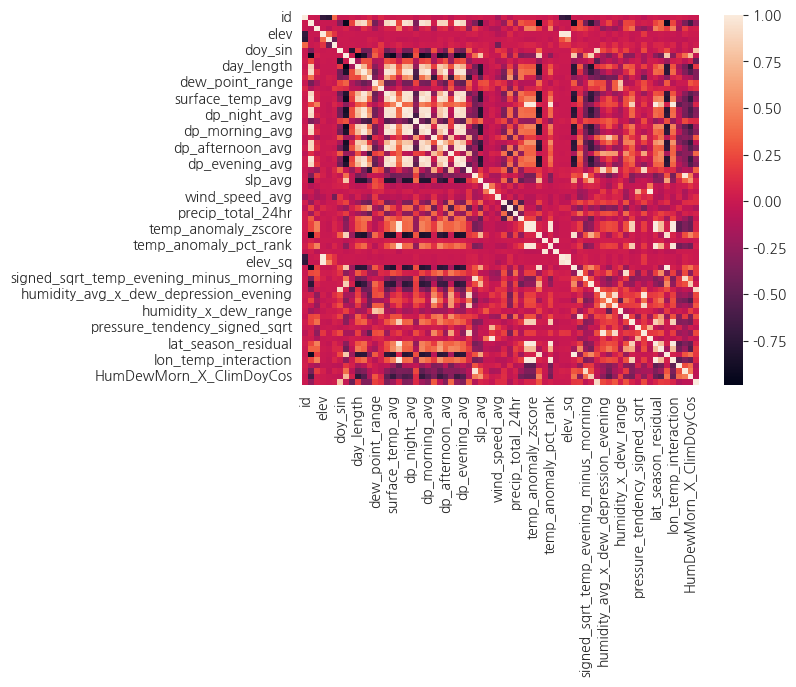

In [25]:
corr = train_df.corr()
sns.heatmap(corr)

> Export

In [26]:
# export df
train_df.to_csv("./input/processed/train_df_final_v5.csv", index=False)
test_df.to_csv("./input/processed/test_df_final_v5.csv", index=False)